# **Transforming Real Price Series**

#### **Project Modules**

In [85]:
# project modules

from src.dnn.utils import train_and_predict, l_infinity_loss
from src.returns.utils import compute_log_returns
from src.yahoo_apis.classes import YahooFinanceAPI

#### **Packages**

In [86]:
# packages

import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#### **Download Data and Specify Parameters**

In [87]:
# Parameters
ticker = "AAPL"
start = datetime(year=1995, month=1, day=1)
end = datetime(year=2025, month=6, day=25)

# Download Returns
yf_api = YahooFinanceAPI()
yf_api.download_data(ticker, start, end)
prices = yf_api.get_close_prices()
z = compute_log_returns(prices)

# Loss functions
losses = {
    "L_1":   "mse",
    "L_2":   "mae",
    "L_inf": l_infinity_loss
}

#### **Create DNN Predictions**

In [88]:
preds = {}
results = {}
histories = {}

seq_length = 1

for name, loss_fn in losses.items():
    print(f"\nTraining with {name} loss")
    res, p, history = train_and_predict(
        series=z,
        loss_function=loss_fn,
        scaler=StandardScaler(),
        seq_length=seq_length,
        batch_size=32,
        epochs=250,
        learning_rate=0.01
    )
    results[name] = res
    preds[name] = p
    histories[name] = history



Training with L_1 loss
Epoch 1/250
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1080 - mae: 0.6949 - mape: 166.1386 - mse: 1.1080 - val_loss: 0.4413 - val_mae: 0.4635 - val_mape: 107.5988 - val_mse: 0.4413
Epoch 2/250
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9579 - mae: 0.6733 - mape: 127.7710 - mse: 0.9579 - val_loss: 0.4391 - val_mae: 0.4625 - val_mape: 103.2395 - val_mse: 0.4391
Epoch 3/250
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1370 - mae: 0.6913 - mape: 124.9106 - mse: 1.1370 - val_loss: 0.4377 - val_mae: 0.4623 - val_mape: 102.5242 - val_mse: 0.4377
Epoch 4/250
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9645 - mae: 0.6719 - mape: 119.4063 - mse: 0.9645 - val_loss: 0.4426 - val_mae: 0.4629 - val_mape: 117.4740 - val_mse: 0.4426
Epoch 5/250
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9858 - mae: 0.6738 - mape: 116.2727 - mse: 0.9858 - val_loss: 0.4395 - val_mae: 0.4646 - val_mape: 113.6895 - val_mse: 0.4395
Epoch 6/250
216/216 ━━━━━━━━━━━

#### **Graphs**

Learning Curves

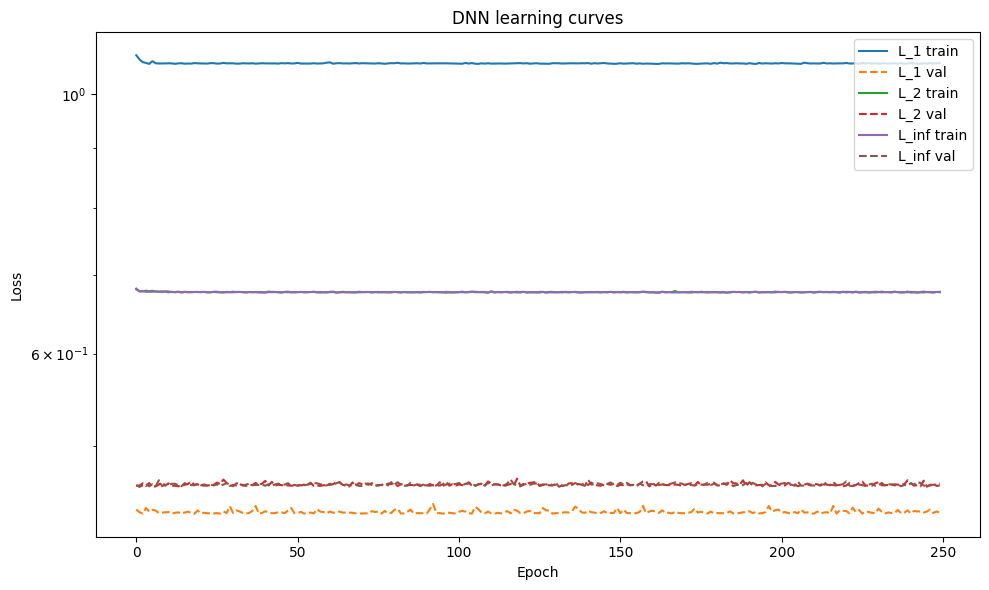

In [89]:
plt.figure(figsize=(10, 6))
for name, hist in histories.items():
    plt.plot(hist.history['loss'], label=f"{name} train")
    # if you have validation loss:
    if 'val_loss' in hist.history:
        plt.plot(hist.history['val_loss'], label=f"{name} val", linestyle='--')
plt.title("DNN learning curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale('log')  # optional: log-scale if losses span orders
plt.legend()
plt.tight_layout()
plt.show()

Returns Comparison

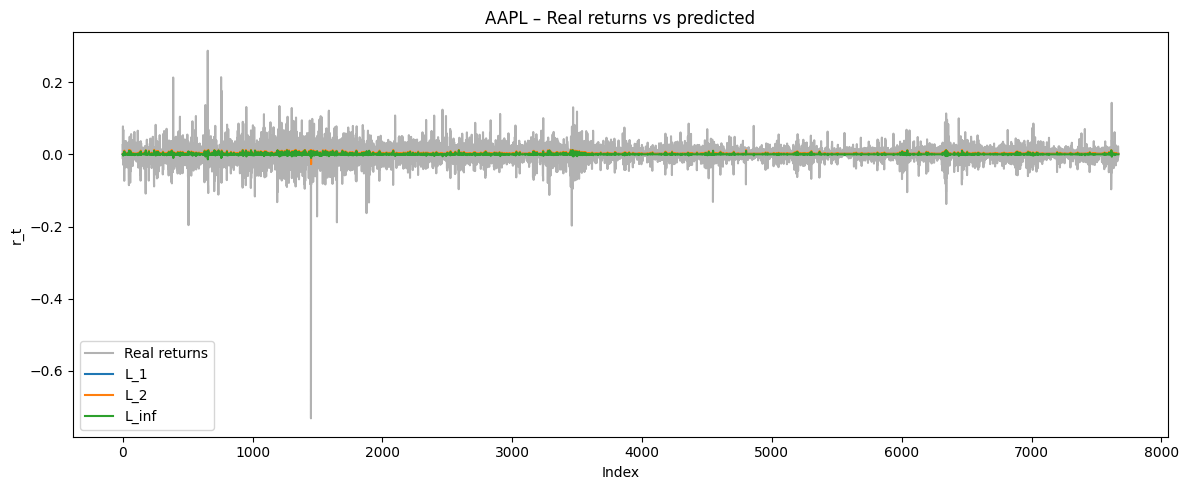

In [90]:
t = np.arange(len(z))
plt.figure(figsize=(12, 5))
plt.plot(t, z, 'k-', alpha=0.3, label='Real returns')
for name, p in preds.items():
    plt.plot(t[seq_length:], p, label=name)
plt.title(f"{ticker} – Real returns vs predicted")
plt.xlabel("Index")
plt.ylabel("r_t")
plt.legend()
plt.tight_layout()
plt.show()

L1 vs L2 Comparison

C:\Users\Iker\AppData\Local\Temp\ipykernel_42224\4117256336.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right')


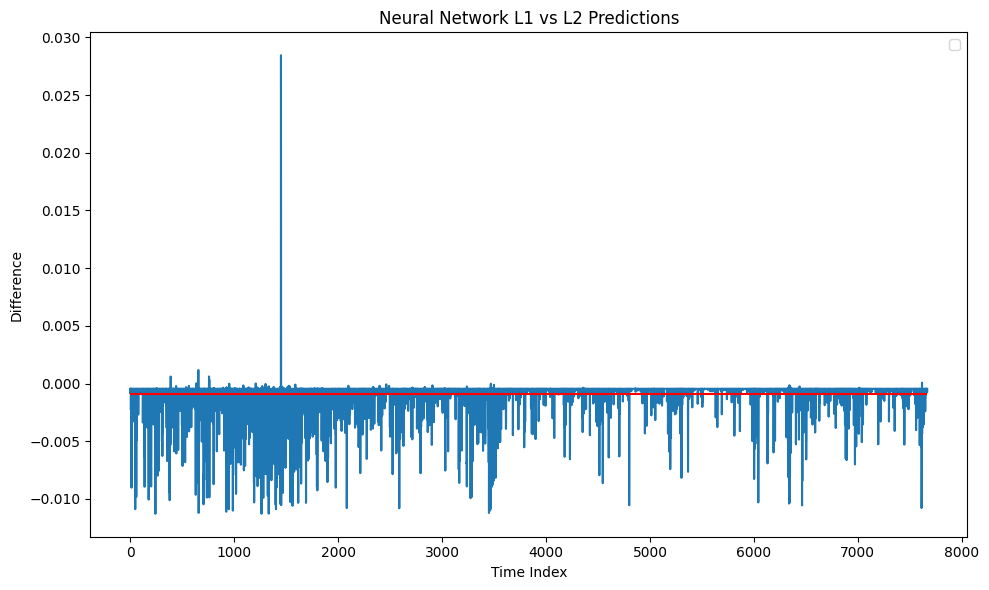


Mean Difference: -0.0009377912501804531


In [91]:
difference = preds["L_1"] - preds["L_2"]
mean_difference = np.mean(difference)

plt.figure(figsize=(10,6))
plt.plot(difference)
plt.hlines(y=mean_difference,xmin=0,xmax=len(difference),colors="red")
plt.title("Neural Network L1 vs L2 Predictions")
plt.xlabel("Time Index")
plt.ylabel("Difference")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

print(f"\nMean Difference: {mean_difference}")

Errors Comparison

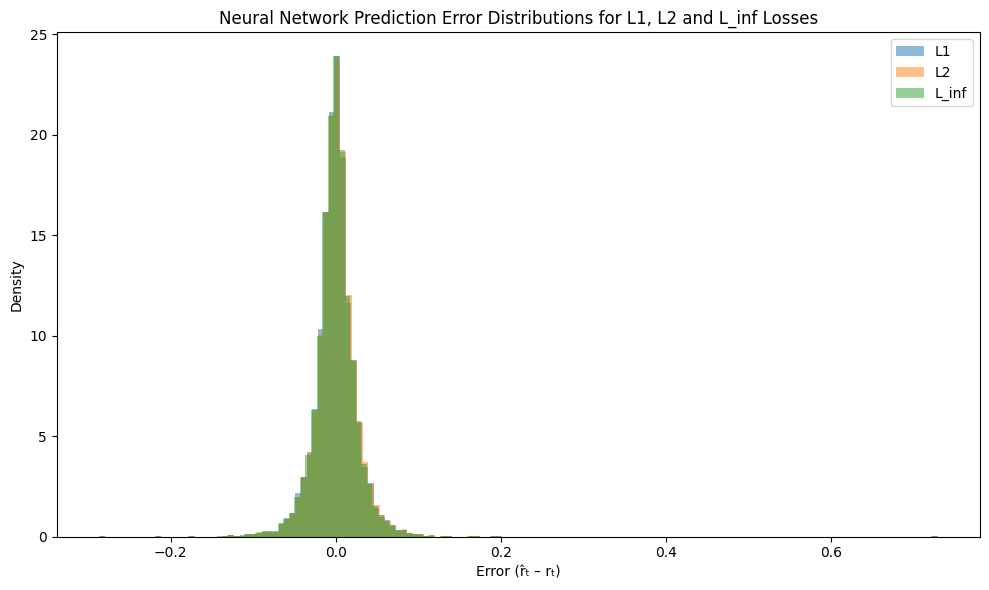

In [92]:
true_r = z[seq_length:]
errors = { name: preds[name] - true_r.flatten() for name in preds }

# 3) Plot
plt.figure(figsize=(10,6))


# Filled histograms
plt.hist(errors["L_1"], bins=150, density=True,
         alpha=0.5, label='L1', color='C0')
plt.hist(errors["L_2"], bins=150, density=True,
         alpha=0.5, label='L2', color='C1')
plt.hist(errors["L_inf"], bins=150, density=True,
         alpha=0.5, label='L_inf', color='C2')

plt.title("Neural Network Prediction Error Distributions for L1, L2 and L_inf Losses")
plt.xlabel("Error (r̂ₜ – rₜ)")
plt.ylabel("Density")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

(-0.2, 0.2)

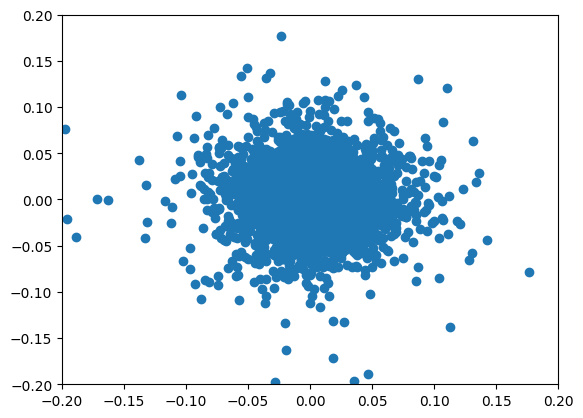

In [93]:
plt.scatter(z[0:-1],z[1:])
plt.xlim([-0.2,0.2])
plt.ylim([-0.2,0.2])

Price Reconstruction (accumulating prediction error)

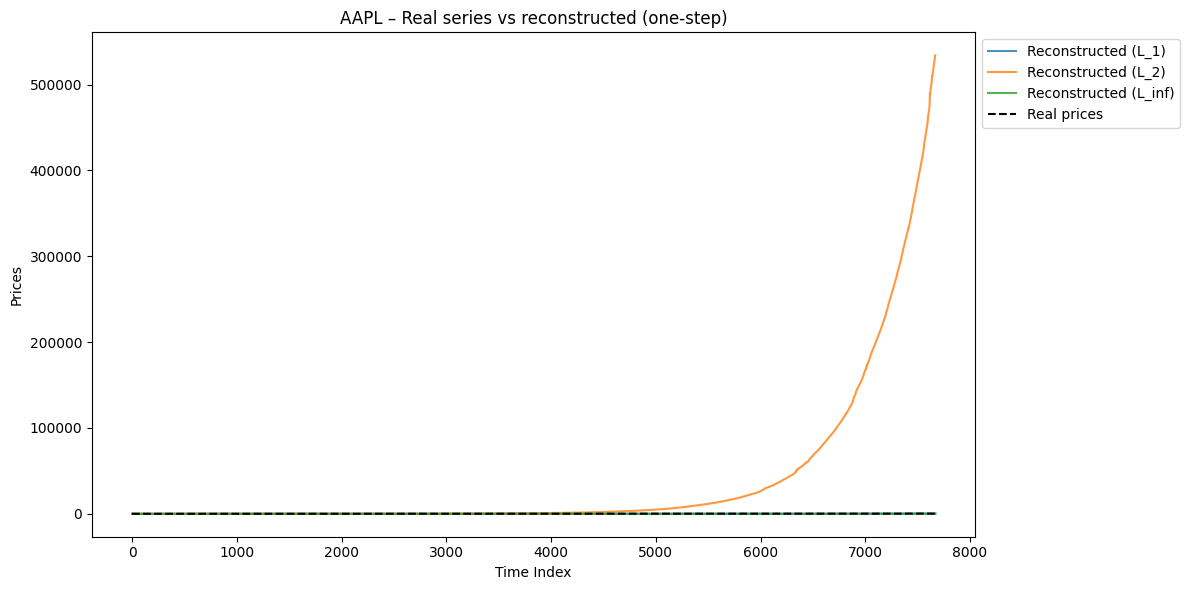

In [94]:
plt.figure(figsize=(12, 6))
for name, p in preds.items():
    rec = [prices[0]]
    for r_hat in p:
        rec.append(rec[-1] * np.exp(r_hat))
    rec = np.array(rec)
    plt.plot(rec, label=f"Reconstructed ({name})", alpha=0.8)
plt.plot(prices[:len(rec)], 'k--', label="Real prices")
plt.title(f"{ticker} – Real series vs reconstructed (one-step)")
plt.xlabel("Time Index")
plt.ylabel("Prices")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

Price Reconstruction (every update_obs steps)

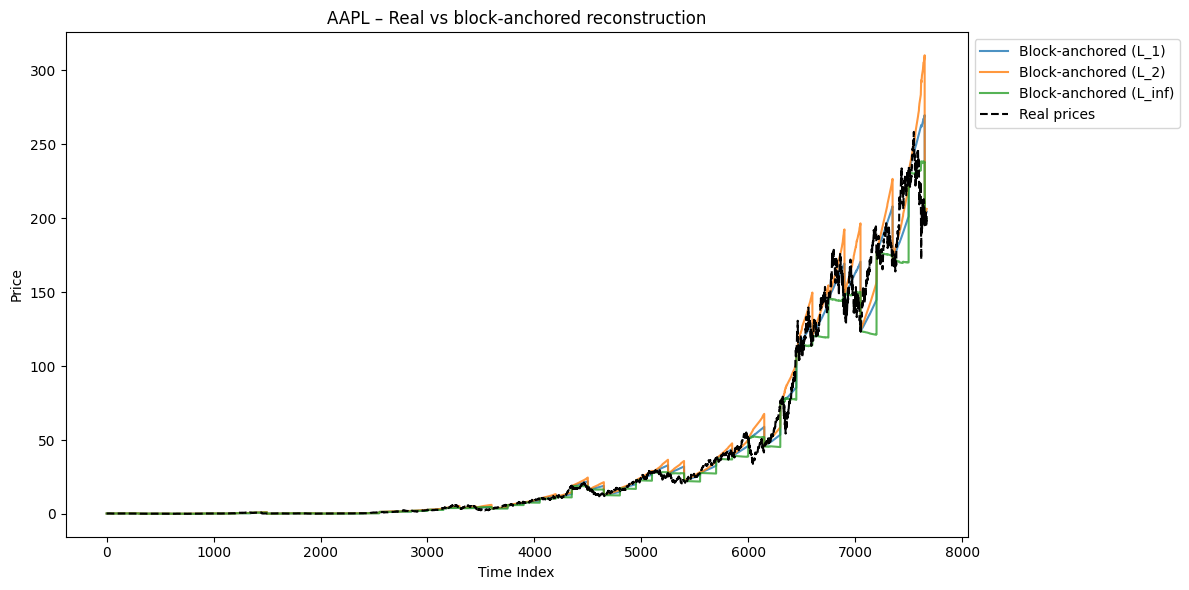

In [95]:
update_obs = 150

plt.figure(figsize=(12, 6))
for name, p in preds.items():
    rec = [prices[0]]  # start from the first real price
    for i, r_hat in enumerate(p):
        # every update_obs steps, re-anchor to the true price at t
        if (i + 1) % update_obs == 0:
            base_price = prices[i + 1]
        else:
            base_price = rec[-1]
        rec.append(base_price * np.exp(r_hat))
    rec = np.array(rec)
    plt.plot(rec, label=f"Block‐anchored ({name})", alpha=0.8)
plt.plot(prices[:len(rec)], 'k--', label="Real prices")
plt.title(f"{ticker} – Real vs block‐anchored reconstruction")
plt.xlabel("Time Index")
plt.ylabel("Price")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()